# Collaboration and Competition

---

In this notebook, we implement a Multi-Agent Reinforcement Learning solution to the Unity ML-Agents Tennis environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed the dependencies in the `environment.yml` file in this directory.

In [1]:
from sys import platform
import os.path
import time
import random
from itertools import count
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from typing import List
from unityagents import UnityEnvironment

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameters to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```
The code below is specific to the servers that were run to train this notebook. Please feel free to edit to ensure it works for your local environment.

In [2]:
if platform.startswith('darwin'):
    env = UnityEnvironment(file_name="./env/Tennis.app")
elif platform.startswith('linux'):
    env = UnityEnvironment(file_name="./env/Tennis_Linux_NoVis/Tennis.x86_64", no_graphics=True)
else:
    raise NotImplemented()

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, we demonstrate how to use the Python API to control the agents and receive feedback from the environment.

Once this cell is executed, you can watch the agents' performance, if they select actions at random with each time step. If you are using a non-headless environment, a window should pop up that allows you to observe the agents.

*Uncomment the code below to see a random interaction with the environment.*

In [5]:
# for i in range(1, 6):                                      # play game for 5 episodes
#     env_info = env.reset(train_mode=False)[brain_name]     # reset the environment
#     states = env_info.vector_observations                  # get the current state (for each agent)
#     scores = np.zeros(num_agents)                          # initialize the score (for each agent)
#     while True:
#         actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
#         actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
#         env_info = env.step(actions)[brain_name]           # send all actions to tne environment
#         next_states = env_info.vector_observations         # get next state (for each agent)
#         rewards = env_info.rewards                         # get reward (for each agent)
#         dones = env_info.local_done                        # see if episode finished
#         scores += env_info.rewards                         # update the score (for each agent)
#         states = next_states                               # roll over states to next time step
#         if np.any(dones):                                  # exit loop if episode finished
#             break
#     print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

### 4. Implementation

#### MATD3

The algorithm used for solving the environment will be Multi-Agent Twin Deep Deterministic Policy Gradient (MATD3), which is described in this paper: [Reducing Overestimation Bias in Multi-Agent Domains Using Double Centralized Critics](https://arxiv.org/abs/1910.01465).

The MATD3 algorithm used implements the following improvements to MADDPG:
* It adopts a twin network architecture for the critics, with two separate streams that result in two separate estimates of the value of the states-actions pairs inputted; the two streams are independent, except for the shared optimizer.
* It implements *Target Policy Smoothing*, which adds gaussian noise not only to the actions to explore the environment as per DDPG and MADDPG, but also to the target actions. This acts as a regularizer because it encourages the policy to generalize over similar actions.
* It delays updates to the online policy network, the online target network, and the twin critic target networks so that the twin critic online network updates at a higher rate. This should allow the value function to achieve more accurate values before it's used to optimze the policy.

##### The Twin Critic model architecture:
The following Twin Critic model was used:
* The input is a concatenation of the states and the actions of all agents in the environment. Since each agent observes a state of size 24 and an action of size 2, and there are 2 agents, the state input is of size (2*(24+2)) = 52.
* The model splits into two independent streams of the following structure each: 52 dim input -> 64 dim fully-connected layer -> Relu activation -> 64 dim fully-connected layer -> Relu activation -> 64 dim fully-connected layer -> Relu activation -> 1 dim linear output

##### The Actor model architecture:
The following Actor model was used:
* The input is the state/observation of a single agent of size 24
* The model has the following structure: 24 dim input -> 64 dim fully-connected layer -> Relu activation -> 64 dim fully-connected layer -> Relu activation -> 64 dim fully-connected layer -> Relu activation -> 2 dim linear output -> Tanh activation
* The tanh activation rescales the action to be between -1 and 1, and is used to ensure that the actions are within the bounds of the environment.

Please refer to the variable `config` below for a dictionary of hyperparameters used to train the agents.

In [6]:
class MultiAgentReplayBuffer:
    def __init__(self, max_buffer_size, num_agents, state_shape, action_size):
        self.max_buffer_size = max_buffer_size
        self.num_agents = num_agents
        self.state_shape = state_shape
        self.action_size = action_size
        self.states = np.full((self.max_buffer_size, *self.state_shape), np.nan)
        self.actions = np.full((self.max_buffer_size, self.num_agents, self.action_size), np.nan)
        self.rewards = np.full((self.max_buffer_size, self.num_agents), np.nan)
        self.next_states = np.full((self.max_buffer_size, *self.state_shape), np.nan)
        self.dones = np.full((self.max_buffer_size, self.num_agents), np.nan)
        self.buffer_size = 0
        self.idx = 0

    def __len__(self):
        return self.buffer_size

    def upsert(self, states, actions, rewards, next_states, dones):
        self.states[self.idx] = states
        self.actions[self.idx] = actions
        self.rewards[self.idx] = rewards
        self.next_states[self.idx] = next_states
        self.dones[self.idx] = dones
        self.buffer_size = min(self.buffer_size + 1, self.max_buffer_size)
        self.idx = (self.idx + 1) % self.max_buffer_size

    def sample(self, batch_size):
        if batch_size > self.buffer_size:
            raise ValueError("Not enough samples in buffer")
        idx = np.random.randint(0, self.buffer_size, batch_size)
        return {
            'batch_size': batch_size,
            'states': self.states[idx],
            'actions': self.actions[idx],
            'rewards': self.rewards[idx],
            'next_states': self.next_states[idx],
            'dones': self.dones[idx]
        }


class MATD3TwinCriticNetwork(nn.Module):
    def __init__(self, all_agents_state_size: int, all_agents_action_size: int, hidden_dims: List[int], device=torch.device('cpu')):
        super(MATD3TwinCriticNetwork, self).__init__()
        self.device = device
        self.all_agents_state_size = all_agents_state_size
        self.all_agents_action_size = all_agents_action_size

        input_dim = self.all_agents_state_size + self.all_agents_action_size
        output_dim = 1

        self.layers_a = nn.ModuleList()
        self.layers_b = nn.ModuleList()
        for i, dim in enumerate(hidden_dims):
            if i == 0:
                self.layers_a.append(nn.Linear(input_dim, dim))
                self.layers_b.append(nn.Linear(input_dim, dim))
            else:
                self.layers_a.append(nn.Linear(hidden_dims[i - 1], dim))
                self.layers_b.append(nn.Linear(hidden_dims[i - 1], dim))
            self.layers_a.append(nn.ReLU())
            self.layers_b.append(nn.ReLU())
        self.layers_a.append(nn.Linear(hidden_dims[-1], output_dim))
        self.layers_b.append(nn.Linear(hidden_dims[-1], output_dim))
        self.to(self.device)

    def forward(self, states, actions):
        s, a = self._format(states, actions)
        xa = torch.cat([s, a], dim=1)
        xb = xa.clone()
        for layer_a, layer_b in zip(self.layers_a, self.layers_b):
            xa = layer_a(xa)
            xb = layer_b(xb)
        return xa, xb

    def qa(self, states, actions):
        s, a = self._format(states, actions)
        x = torch.cat([s, a], dim=1)
        for layer_a in self.layers_a:
            x = layer_a(x)
        return x

    def _format(self, states, actions):
        s, a = states, actions
        if not isinstance(s, torch.Tensor):
            s = torch.tensor(s,
                             device=self.device,
                             dtype=torch.float32)
        if not isinstance(a, torch.Tensor):
            a = torch.tensor(a,
                             device=self.device,
                             dtype=torch.float32)
        if s.dim() == 1:
            s = s.unsqueeze(0)
        if a.dim() == 1:
            a = a.unsqueeze(0)
        assert s.dim() == 2 and a.dim() == 2
        return s, a


class MATD3ActorNetwork(nn.Module):
    def __init__(self, state_size: int, action_size: int, hidden_dims: List[int], device=torch.device('cpu')):
        super(MATD3ActorNetwork, self).__init__()
        self.device = device
        self.state_size = state_size
        self.action_size = action_size

        input_dim = state_size
        output_dim = action_size

        self.layers = nn.ModuleList()
        for i, dim in enumerate(hidden_dims):
            if i == 0:
                self.layers.append(nn.Linear(input_dim, dim))
            else:
                self.layers.append(nn.Linear(hidden_dims[i - 1], dim))
            self.layers.append(nn.ReLU())
        self.layers.append(nn.Linear(hidden_dims[-1], output_dim))
        self.layers.append(nn.Tanh())
        self.to(device)

    def forward(self, state):
        x = self._format(state)
        for layer in self.layers:
            x = layer(x)
        return x

    def _format(self, state):
        if not isinstance(state, torch.Tensor):
            state = torch.tensor(state,
                                 device=self.device,
                                 dtype=torch.float32)
        if state.dim() == 1:
            state = state.unsqueeze(0)
        assert state.dim() == 2
        return state


class MATD3Agent:
    def __init__(self, state_size, action_size, all_agents_state_size, all_agents_action_size, config):
        self.state_size = state_size
        self.action_size = action_size
        self.all_agents_state_size = all_agents_state_size
        self.all_agents_action_size = all_agents_action_size
        self.config = config

        if 'cuda' in self.config['device'] and torch.cuda.is_available():
            device = torch.device(self.config['device'])
        else:
            device = torch.device('cpu')

        self.critic_online = MATD3TwinCriticNetwork(self.all_agents_state_size, self.all_agents_action_size, hidden_dims=self.config['critic_hidden_dims'], device=device)
        self.critic_target = MATD3TwinCriticNetwork(self.all_agents_state_size, self.all_agents_action_size, hidden_dims=self.config['critic_hidden_dims'], device=device)
        self.update_critic_target(1.0)

        self.actor_online = MATD3ActorNetwork(self.state_size, self.action_size, hidden_dims=self.config['actor_hidden_dims'], device=device)
        self.actor_target = MATD3ActorNetwork(self.state_size, self.action_size, hidden_dims=self.config['actor_hidden_dims'], device=device)
        self.update_actor_target(1.0)

        self.critic_optimizer = optim.Adam(self.critic_online.parameters(), lr=self.config['critic_lr'])
        self.actor_optimizer = optim.Adam(self.actor_online.parameters(), lr=self.config['actor_lr'])

    def optimize(self, agent_idx: int, experiences, target_next_actions, optimize_policy: bool):
        batch_size = experiences['batch_size']
        states = torch.from_numpy(experiences['states']).to(self.actor_online.device, dtype=torch.float32)
        actions = torch.from_numpy(experiences['actions']).to(self.actor_online.device, dtype=torch.float32)
        rewards = torch.from_numpy(experiences['rewards']).to(self.actor_online.device, dtype=torch.float32)
        next_states = torch.from_numpy(experiences['next_states']).to(self.actor_online.device, dtype=torch.float32)
        dones = torch.from_numpy(experiences['dones']).to(self.actor_online.device, dtype=torch.float32)

        states_flat = states.reshape(batch_size, -1)
        actions_flat = actions.reshape(batch_size, -1)
        next_states_flat = next_states.reshape(batch_size, -1)

        states_self = states[:, agent_idx, :]
        rewards_self = rewards[:, agent_idx].unsqueeze(1)
        dones_self = dones[:, agent_idx].unsqueeze(1)

        target_next_actions_flat = target_next_actions.reshape(batch_size, -1)

        with torch.no_grad():
            target_qa, target_qb = self.critic_target(next_states_flat, target_next_actions_flat)

            # the min of the twin critic value estimates is used to reduce overestimation bias
            target_q = rewards_self + self.config['gamma'] * torch.min(target_qa, target_qb) * (1 - dones_self)

        target_q = target_q.to(self.critic_online.device)
        qa, qb = self.critic_online(states_flat, actions_flat)
        value_loss = (qa - target_q).pow(2).mul(0.5).mean() + (qb - target_q).pow(2).mul(0.5).mean()
        self.critic_optimizer.zero_grad()
        value_loss.backward()
        nn.utils.clip_grad_norm_(self.critic_online.parameters(), self.config['critic_gradient_clip_value'])
        self.critic_optimizer.step()

        if optimize_policy:
            greedy_action = self.actor_online(states_self)
            actions[:, agent_idx] = greedy_action

            # we use one of the streams from the online value model for policy loss, the same stream every time
            q_value = self.critic_online.qa(states_flat, actions.reshape(batch_size, -1))

            # the second term was added as a regularizer per MADDPG codebase (https://github.com/openai/maddpg/blob/3ceefa0ada3ff31d633dd0bde8ff95213ce99be3/maddpg/trainer/maddpg.py#L56)
            policy_loss = -q_value.mean() + (greedy_action.pow(2).mean() * 1e-3)
            self.actor_optimizer.zero_grad()
            policy_loss.backward()
            torch.nn.utils.clip_grad_norm_(self.actor_online.parameters(), self.config['actor_gradient_clip_value'])
            self.actor_optimizer.step()

    def select_online_action(self, state, noise_std_dev: float, noise_clip_range: float):
        greedy_action = self.actor_online(state).cpu().detach().numpy()
        noise = np.random.normal(0.0, scale=noise_std_dev, size=self.action_size)
        noise = np.clip(noise, -abs(noise_clip_range), abs(noise_clip_range))

        # TODO dynamically rescale clip of action to support other environments; currently it's between -1 and 1 only
        noisy_action = np.clip(greedy_action + noise, -1, 1)
        return noisy_action

    def select_target_action(self, state, noise_std_dev: float, noise_clip_range: float, use_numpy: bool = False):
        greedy_action = self.actor_target(state)
        noise = torch.randn_like(greedy_action) * noise_std_dev
        noise = torch.clamp(noise, -noise_clip_range, noise_clip_range)
        noisy_action = greedy_action + noise

        # TODO dynamically rescale clip of action to support other environments; currently it's between -1 and 1 only
        noisy_action = torch.clamp(noisy_action, -1, 1)
        return noisy_action.detach().cpu().numpy() if use_numpy else noisy_action

    def update_critic_target(self, tau: float):
        self._update_target(self.critic_target, self.critic_online, tau)

    def update_actor_target(self, tau: float):
        self._update_target(self.actor_target, self.actor_online, tau)

    @staticmethod
    def _update_target(target, online, tau: float):
        for target_param, param in zip(target.parameters(), online.parameters()):
            target_param.data.copy_(target_param.data * (1.0 - tau) + param.data * tau)

    def save_checkpoints(self, name: str):
        print("Saving checkpoints for {}".format(name))
        torch.save({
            'critic_online': self.critic_online.state_dict(),
            'critic_optimizer': self.critic_optimizer.state_dict(),
            'actor_online': self.actor_online.state_dict(),
            'actor_optimizer': self.actor_optimizer.state_dict(),
        }, os.path.join(self.config['checkpoint_dir'], '{}.tar'.format(name)))

    def load_checkpoints(self, name: str, train_mode: bool = False):
        message = "Loading checkpoints for {}".format(name)
        if train_mode:
            message += " in train mode"
        else:
            message += " in eval mode"
        print(message)

        checkpoint = torch.load(os.path.join(self.config['checkpoint_dir'], '{}.tar'.format(name)))
        self.critic_online.load_state_dict(checkpoint['critic_online'])
        self.critic_optimizer.load_state_dict(checkpoint['critic_optimizer'])
        self.actor_online.load_state_dict(checkpoint['actor_online'])
        self.actor_optimizer.load_state_dict(checkpoint['actor_optimizer'])

        if train_mode:
            self.critic_online.train()
            self.actor_online.train()
        else:
            self.critic_online.eval()
            self.actor_online.eval()


class MATD3Trainer:
    def __init__(self, config, env):
        self.config = config

        torch.manual_seed(self.config['seed'])
        np.random.seed(self.config['seed'])
        random.seed(self.config['seed'])

        self.env = env
        self.brain_name = self.env.brain_names[0]
        self.brain = self.env.brains[self.brain_name]
        env_info = self.env.reset(train_mode=True)[self.brain_name]
        self.num_agents = len(env_info.agents)

        self.action_size_per_agent = self.brain.vector_action_space_size
        self.all_agents_state_size = env_info.vector_observations.size
        self.all_agents_action_size = self.action_size_per_agent * self.num_agents

        self.replay_buffer = MultiAgentReplayBuffer(self.config['max_buffer_size'], self.num_agents,
                                                    env_info.vector_observations.shape, self.action_size_per_agent)
        self.agents = [MATD3Agent(env_info.vector_observations[agent_idx].size, action_size, self.all_agents_state_size,
                                  self.all_agents_action_size, self.config) for agent_idx in range(self.num_agents)]

    def train(self):
        self.episode_rewards = []
        self.episode_timesteps = []
        self.episode_timestamps = []
        self.episode_durations = []

        training_start = time.time()
        exploration_noise = self.config['exploration_noise_std_dev_max']

        print("Training...")
        for episode in range(1, self.config['max_episodes'] + 1):
            episode_start = time.time()
            env_info = self.env.reset(train_mode=True)[self.brain_name]
            rewards_sum = np.zeros(self.num_agents)

            for step in count(1):
                states = env_info.vector_observations
                actions = [agent.select_online_action(states[agent_idx], exploration_noise, self.config['exploration_noise_clip_range']) for agent_idx, agent in enumerate(self.agents)]
                actions = np.array(actions).squeeze()
                env_info = self.env.step(actions)[self.brain_name]
                next_states = env_info.vector_observations
                rewards = env_info.rewards
                dones = env_info.local_done

                self.replay_buffer.upsert(states, actions, rewards, next_states, dones)
                rewards_sum += rewards

                # dynamically decay the std_dev of the exploration noise with each timestep
                exploration_noise = max(exploration_noise * self.config['exploration_noise_std_dev_decay'],
                                        self.config['exploration_noise_std_dev_min'])

                if len(self.replay_buffer) >= self.config['min_buffer_size']: # warmup the buffer
                    experiences = self.replay_buffer.sample(self.config['batch_size'])

                    # get the next actions from the target policy for all agents
                    target_next_actions = [agent.select_target_action(experiences['next_states'][:, agent_idx, :], self.config['tps_noise_std_dev'], self.config['tps_noise_clip_range'],use_numpy=False) for agent_idx, agent in enumerate(self.agents)]
                    target_next_actions = torch.stack(target_next_actions, dim=1)
                    optimize_policy = step % self.config['optimize_policy_every_steps'] == 0

                    for agent_idx, agent in enumerate(self.agents):
                        agent.optimize(agent_idx, experiences, target_next_actions, optimize_policy)

                if step % self.config['update_critic_target_every_steps'] == 0:
                    for agent in self.agents:
                        agent.update_critic_target(self.config['tau'])

                if step % self.config['update_actor_target_every_steps'] == 0:
                    for agent in self.agents:
                        agent.update_actor_target(self.config['tau'])

                if np.any(dones):
                    self.episode_timesteps.append(step)
                    self.episode_rewards.append(rewards_sum)
                    episode_end = time.time()
                    self.episode_timestamps.append(episode_end)
                    episode_duration = episode_end - episode_start
                    self.episode_durations.append(episode_duration)
                    break

            mean_100_reward = np.max(self.episode_rewards[-100:], axis=1).mean() if len(
                self.episode_rewards) >= 100 else np.nan
            goal_reached = mean_100_reward >= self.config['goal_mean_100_reward']

            duration = time.strftime("%H:%M:%S", time.gmtime(time.time() - training_start))
            message = ("{} - episode {:05}, timesteps {:07}, train score 1ep {:.3f}".format(
                duration,
                episode,
                np.sum(self.episode_timesteps, dtype=np.intc),
                np.max(self.episode_rewards[-1:], axis=1).mean()))
            message += ", train score 100ep {:.3f}".format(mean_100_reward) if mean_100_reward is not np.nan else ""

            if episode % self.config['log_every_episodes'] == 0:
                print(message)

            if goal_reached:
                print(message)
                print("Goal reached! Training stopped.")
                self.save_checkpoints(episode)
                break

            if episode == self.config['max_episodes']:
                print(message)
                print("Max episodes reached! Training stopped.")
                self.save_checkpoints(episode)
                break

            if episode % self.config['save_every_episodes'] == 0:
                self.save_checkpoints(episode)

    def save_checkpoints(self, episode: int):
        for agent_idx, agent in enumerate(self.agents):
            agent.save_checkpoints('episode{:05}_agent{}'.format(episode, agent_idx))

    def load_checkpoints(self, episode: int, train_mode: bool = False):
        for agent_idx, agent in enumerate(self.agents):
            agent.load_checkpoints('episode{:05}_agent{}'.format(episode, agent_idx), train_mode)

    def demo(self, checkpoint_episode: int, num_episodes=100):
        self.load_checkpoints(checkpoint_episode, train_mode=False)
        print("Demo...")
        episode_timesteps = []
        episode_rewards = []
        for episode in range(1, num_episodes + 1):
            env_info = self.env.reset(train_mode=False)[self.brain_name]
            rewards_sum = np.zeros(self.num_agents)
            for step in count(1):
                states = env_info.vector_observations
                actions = [agent.select_online_action(states[agent_idx], 0, 0) for agent_idx, agent in
                           enumerate(self.agents)]
                actions = np.array(actions).squeeze()
                env_info = self.env.step(actions)[self.brain_name]
                rewards = env_info.rewards
                rewards_sum += rewards
                dones = env_info.local_done
                if np.any(dones):
                    episode_timesteps.append(step)
                    episode_rewards.append(rewards_sum)
                    break
            if episode == num_episodes:
                print("Max episodes reached! Demo stopped.")
        return np.array(episode_timesteps), np.array(episode_rewards), np.max(episode_rewards, axis=1).mean()


config = {
    'critic_hidden_dims': [64, 64, 64],
    'critic_lr': 3e-4,
    'critic_gradient_clip_value': 0.5,
    'actor_hidden_dims': [64, 64, 64],
    'actor_lr': 3e-4,
    'actor_gradient_clip_value': 0.5,
    'gamma': 0.99,
    'tau': 0.01,
    'checkpoint_dir': os.path.join(os.path.dirname(os.path.realpath('__file__')), 'checkpoints'),
    'max_buffer_size': 10000,
    'min_buffer_size': 320,
    'batch_size': 64,
    'max_episodes': 50000,
    'exploration_noise_std_dev_max': 0.5,
    'exploration_noise_std_dev_min': 0.05,
    'exploration_noise_clip_range': float('inf'),
    'exploration_noise_std_dev_decay': 0.9999,
    'tps_noise_std_dev': 0.05,
    'tps_noise_clip_range': 0.5,
    'optimize_policy_every_steps': 2,
    'update_critic_target_every_steps': 2,
    'update_actor_target_every_steps': 2,
    'goal_mean_100_reward': 0.6,
    'save_every_episodes': 10000,
    'log_every_episodes': 100,
    'seed': 2022,
    'device': 'cuda:0',  # TODO - enable DistributedDataParallel for multi-GPU training
}
matd3 = MATD3Trainer(config, env)
matd3.train()

Training...
00:00:22 - episode 00100, timesteps 0001553, train score 1ep 0.000, train score 100ep 0.008
00:00:56 - episode 00200, timesteps 0002971, train score 1ep 0.000, train score 100ep 0.000
00:01:28 - episode 00300, timesteps 0004390, train score 1ep 0.000, train score 100ep 0.000
00:02:08 - episode 00400, timesteps 0006153, train score 1ep 0.000, train score 100ep 0.011
00:02:46 - episode 00500, timesteps 0007807, train score 1ep 0.000, train score 100ep 0.011
00:03:20 - episode 00600, timesteps 0009401, train score 1ep 0.000, train score 100ep 0.008
00:03:57 - episode 00700, timesteps 0011092, train score 1ep 0.000, train score 100ep 0.010
00:04:32 - episode 00800, timesteps 0012699, train score 1ep 0.000, train score 100ep 0.007
00:05:06 - episode 00900, timesteps 0014119, train score 1ep 0.000, train score 100ep 0.000
00:05:37 - episode 01000, timesteps 0015539, train score 1ep 0.000, train score 100ep 0.000
00:06:15 - episode 01100, timesteps 0017028, train score 1ep 0.000, 

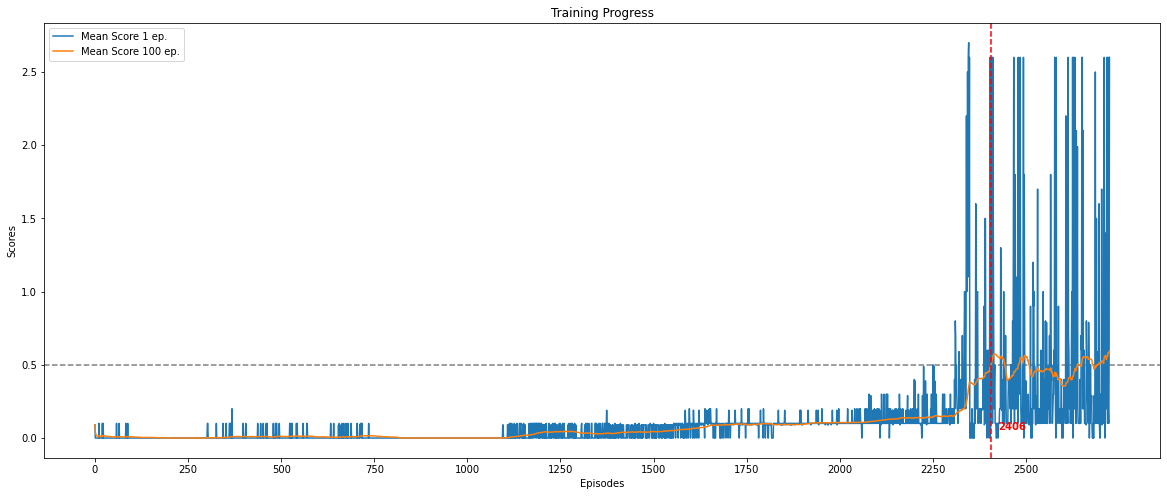

In [9]:
import matplotlib.pyplot as plt
episode_rewards = np.max(matd3.episode_rewards, axis=1)
mean_100_scores = np.flip([episode_rewards[max(t-100, 0):t+1].mean() for t in reversed(range(len(episode_rewards)))])
plt.rcParams['figure.figsize'] = [20, 8]
plt.title("Training Progress")
plt.xticks(np.arange(0, len(episode_rewards), step=250))
plt.axhline(y=0.5, color='grey', linestyle='--')
plt.plot(np.arange(len(episode_rewards)), np.array(episode_rewards).squeeze(), label="Mean Score 1 ep.")
plt.plot(np.arange(len(mean_100_scores)), np.array(mean_100_scores).squeeze(), label="Mean Score 100 ep.")
threshold_episode = np.argwhere(mean_100_scores >= 0.5).squeeze()[0]
plt.axvline(x=threshold_episode, color='red', linestyle='--')
plt.ylabel("Scores")
plt.xlabel("Episodes")
plt.text(threshold_episode + plt.xlim()[1] * 0.02, 0 + plt.ylim()[1]*0.02, str(threshold_episode), horizontalalignment='center', fontweight='bold', color='red')
plt.legend()

Per the figure above, the environment was solved after 2406 episodes, meaning that the mean reward of 100 consecutive episodes for 2 agents was at least 0.5.
The highest performance network parameters have been saved in files `./checkpoints/episode_02725_agent0.tar` and `./checkpoints/episode_02725_agent1.tar`

### Ideas for improvement
* The Gaussian process for which exploration noise was added to the actor's greedy action was overly simplistic; exploring other options for exploration may improve training time, like using an Ornstein-Uhlenbeck process
* Implementations of other multi-agent algorithms, including a mutli-agent SAC or PPO, may take fewer episodes to solve the environment.
* Modifying the reward function to encourage collaboration, perhaps by summing the rewards of both agents, may improve the performance.
* Given that there are multiple agents, it may be faster to use a distributed architecture for training and backpropagate asynchronously; numerous todos were left as comments above to support a multi-GPU setup, but an async approach needs to be defined
* Normalizing the inputs and rewards may improve stability of learning.
* Hyperparameters were selected via trial and error. Grid-search of hyperparameters may find more optimal values.

### References
* [MATD3 Paper](https://arxiv.org/abs/1910.01465)
* [MATD3 Code](https://github.com/JohannesAck/tf2multiagentrl)
* [MADDPG Paper](https://arxiv.org/abs/1706.02275)
* [MADDPG Code](https://github.com/openai/maddpg)
* [Grokking Deep Reinforcement Learning](https://www.manning.com/books/grokking-deep-reinforcement-learning) book, chapter 12 on TD3
* [Code](https://github.com/mimoralea/gdrl) for Grokking Deep Reinforcement Learning book